In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [2]:
from pysquid.linearModel import LinearModelTV_ADMM
from pysquid.kernels.kernel import Kernel
from pysquid.kernels.magpsf import GaussianKernel
from pysquid.util.helpers import *

In [332]:
params = np.array([1., 1., 1.])
sigma = 0.01
Ly, Lx = 16, 16
padding = np.array([2, 2])
phishape = np.array([Ly, Lx])
gshape = phishape + 2*padding
Ly_pad, Lx_pad = gshape

In [333]:
kern = GaussianKernel(phishape, padding=padding, params=params, edges=True)

In [336]:
gtrue = np.zeros(gshape)
gtrue[8:-8, 8:-8] = 1.

phitrue = kern.applyM(gtrue).real
scale = phitrue.ptp()
# Everything is nicer when its order 1
phitrue /= scale
gtrue /= scale
data = phitrue + sigma * np.random.randn(*phishape)

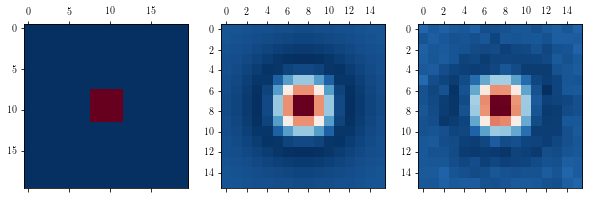

In [337]:
fig, axes = plt.subplots(1, 3, figsize=(10,4))

axes[0].matshow(gtrue)
axes[1].matshow(phitrue)
axes[2].matshow(data)

In [338]:
from pysquid.infercurrents.deconvolve import TVDeconvolver

In [339]:
def testNLL(gfield, phi):
    mphi = model.kernel.applyM(gfield.reshape(model.Ly_pad,-1)).real
    res = phi.ravel() - mphi.ravel()
    return res.dot(res)/2*model.sigma**2, admm.mu_reg*admm.TV(gfield).sum()

def showNLLComponents(gfield, phi):
    fid, tv = testNLL(gfield, phi)
    print("Fidelity contribution = {}, TV contribution = {}".format(fid, tv))

In [340]:
sigma**2

0.0001

In [353]:
decon = TVDeconvolver(kern, gamma=sigma**2/7.)

In [354]:
gsol0 = decon.deconvolve(data.ravel(), iprint=1, eps_abs=1E-12, eps_rel=1E-12)
gsol = gsol0.reshape(gshape)

Initial cost = 4.302e+00
Iteration limit reached
Final cost = 1.441e-02


0.009697707349474102 0.01


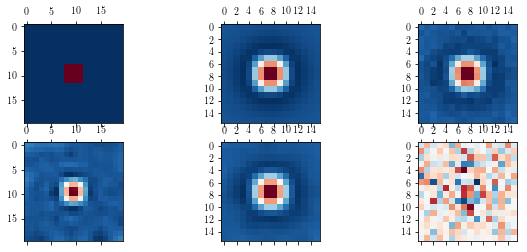

In [355]:
fig, axes = plt.subplots(2, 3, figsize=(10,4))

axes[0,0].matshow(gtrue)
axes[0,1].matshow(phitrue)
axes[0,2].matshow(data)

axes[1,0].matshow(gsol0.reshape(gshape))
phisol = decon.M.dot(gsol0).reshape(phishape)
axes[1,1].matshow(phisol)
axes[1,2].matshow(phisol - data)
print(np.std(phisol-data), sigma)

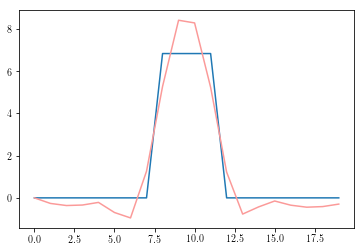

In [356]:
plt.plot(gtrue[10])
plt.plot(gsol[10]-gsol[10,0])